## **SML FINAL PROJECT: PCA with KNN on Adult Dataset**
### Author - Velamuri Yoganandam
---
This file contains the implementation of PCA with KNN on Adult Dataset
All the cells in the file must be executed in the same order for the code to run without any errors.


In [1]:
!pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo

def load_dataset():
  # fetch dataset
  adult = fetch_ucirepo(id=2)

  # data (as pandas dataframes)
  X = adult.data.features
  y = adult.data.targets

  # metadata
  print(adult.metadata)

  # variable information
  variables_info = adult.variables
  print(variables_info)

  return X, y, variables_info

In [3]:
X_raw, y_raw, var_info = load_dataset()

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Mon Aug 07 2023', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAG

In [4]:
import pandas as pd
def print_unique_feature_values(X, var_info=var_info):
  all_features = var_info[var_info.role == 'Feature']
  features = all_features[all_features['type'] =='Categorical']
  # Feature 'sex' is a binary type which is categorical too
  other_categorical = all_features[all_features['type'] == 'Binary']
  features = pd.concat((features, other_categorical), axis=0)
  df = pd.DataFrame(columns=['feature', 'unique_value_count', 'unique_values', 'has \'?\''])
  for i, feature in features.iterrows():
    name = feature['name']
    unique = X[name].unique().T
    df.loc[len(df.index)] = [name, len(unique), unique, '?' in unique.tolist()]
  display(df)
print_unique_feature_values(X_raw)

,feature,unique_value_count,unique_values,has '?'
0,workclass,10,"[State-gov, Self-emp-not-inc, Private, Federal...",True
1,education,16,"[Bachelors, HS-grad, 11th, Masters, 9th, Some-...",False
2,marital-status,7,"[Never-married, Married-civ-spouse, Divorced, ...",False
3,occupation,16,"[Adm-clerical, Exec-managerial, Handlers-clean...",True
4,relationship,6,"[Not-in-family, Husband, Wife, Own-child, Unma...",False
5,race,5,"[White, Black, Asian-Pac-Islander, Amer-Indian...",False
6,native-country,43,"[United-States, Cuba, Jamaica, India, ?, Mexic...",True
7,sex,2,"[Male, Female]",False


In [5]:
print(y_raw.income.unique())

['<=50K' '>50K' '<=50K.' '>50K.']


Here, we can observe that income values have duplicates. There are actually just two categories here, but 4 are present due to improperly recorded values.

'<=50K' and '<=50K.' are same except for the '.' at the end.

Similarly '>50K' and '>50K.' are same.

In [6]:
def print_unknowns(X):
  all_feature_names = var_info[var_info.role == 'Feature']['name']
  df = pd.DataFrame(columns=['feature', '\'?\'count'])
  for f_name in all_feature_names:
    count = len(X[X[f_name] == '?'].index)
    df.loc[len(df.index)] = [f_name, count]
    #print(f'{f_name} : {count}')
  display(df)
print(X_raw.shape)
print_unknowns(X_raw)

(48842, 14)


,feature,'?'count
0,age,0
1,workclass,1836
2,fnlwgt,0
3,education,0
4,education-num,0
5,marital-status,0
6,occupation,1843
7,relationship,0
8,race,0
9,sex,0


We observe unknowns ('?') as well, apart from the nan values.

Let's remove the rows that have '?' and nan values in them.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

def preprocess(features, labels, var_info):
  # Create copies to avoid changing raw features and labels
  X = features.copy()
  y = labels.copy()

  X.isna().sum()

  # Clean the data - remove missing value rows
  features_missing_values = var_info[var_info['missing_values'] == 'yes']
  rows_to_remove = set()
  for index, row in features_missing_values.iterrows():
    feature_name = row['name']
    rows_to_remove.update(X.index[X[feature_name].isna()].tolist());

  # Clean further - remove data with '?' values in them
  all_feature_names = var_info[var_info.role == 'Feature']['name']
  for feature_name in all_feature_names:
    rows_to_remove.update(X[X[feature_name] == '?'].index)

  X.drop(rows_to_remove, axis = 0, inplace=True)
  y.drop(rows_to_remove, axis = 0, inplace=True)

  # Encode categorical feature values and store encoders to later decode them
  categorical = var_info[var_info['type'] == 'Categorical']
  encoders = pd.DataFrame(columns=['name', 'encoders'])
  for index, row in categorical.iterrows():
    feature_name = row['name']
    le = LabelEncoder()
    X[feature_name] = le.fit_transform(X[feature_name])
    encoders.loc[len(encoders.index)] = [feature_name, le]
  le = LabelEncoder()
  X['sex'] = le.fit_transform(X['sex'])
  encoders.loc[len(encoders.index)] = ['sex', le]
  le = LabelEncoder()
  y['income'].replace({'<=50K.': '<=50K', '>50K.': '>50K'}, inplace=True)
  y['income'] = le.fit_transform(y['income'])
  encoders.loc[len(encoders.index)] = ['income', le]

  return X, y, encoders


In [8]:
X, y, encoders = preprocess(X_raw, y_raw, var_info)

In [9]:
print_unique_feature_values(X_raw)
print_unique_feature_values(X)

,feature,unique_value_count,unique_values,has '?'
0,workclass,10,"[State-gov, Self-emp-not-inc, Private, Federal...",True
1,education,16,"[Bachelors, HS-grad, 11th, Masters, 9th, Some-...",False
2,marital-status,7,"[Never-married, Married-civ-spouse, Divorced, ...",False
3,occupation,16,"[Adm-clerical, Exec-managerial, Handlers-clean...",True
4,relationship,6,"[Not-in-family, Husband, Wife, Own-child, Unma...",False
5,race,5,"[White, Black, Asian-Pac-Islander, Amer-Indian...",False
6,native-country,43,"[United-States, Cuba, Jamaica, India, ?, Mexic...",True
7,sex,2,"[Male, Female]",False


,feature,unique_value_count,unique_values,has '?'
0,workclass,7,"[5, 4, 2, 0, 1, 3, 6]",False
1,education,16,"[9, 11, 1, 12, 6, 15, 7, 5, 10, 8, 14, 4, 0, 1...",False
2,marital-status,7,"[4, 2, 0, 3, 5, 1, 6]",False
3,occupation,14,"[0, 3, 5, 9, 7, 11, 13, 4, 6, 12, 2, 10, 1, 8]",False
4,relationship,6,"[1, 0, 5, 3, 4, 2]",False
5,race,5,"[4, 2, 1, 0, 3]",False
6,native-country,41,"[38, 4, 22, 18, 25, 32, 15, 8, 1, 10, 19, 29, ...",False
7,sex,2,"[1, 0]",False


# Observations after cleaning
Observe here, the categorical features with improper values('?' or nan) are expected to be two values down after cleaning.

But the feature 'workclass' is down by three values.

It might be explained as the additional value that went missing after cleaning might have had improper values in other rows.

In [10]:
y.income.unique()

array([0, 1])

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Let's setup scaler only for the numerical features. Here, these can be identified from the variable info (var_info) we have. Numerical features have type as Integer in our dataset.

In [12]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Selecting numerical features
numerical_features = var_info[var_info['type'] == 'Integer']

# Setup ColumnTransformer
column_transformer = ColumnTransformer([
        ('standardscaler', StandardScaler(), numerical_features['name'].to_numpy())
    ], remainder='passthrough')

# PCA with KNN on UCI Adult dataset

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

knn = KNeighborsClassifier()

pipe = Pipeline(
    [
        ("scaler", column_transformer),
        ("PCA", PCA(n_components = 0.95, svd_solver='full')),
        ("KNN", knn)
    ]
)

# Left 1 out of these values to avoid overfitting.
# Used only odd k values to avoid ties at the decision boundary
k_vals = np.arange(1,31, 2)
pca_n_vals = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
# 10-Fold Cross Validation
param_grid = {
    'KNN__n_neighbors': k_vals,
    'PCA__n_components': pca_n_vals
}

# Define the GridSearchCV object with k-fold cross-validation
grid_search = GridSearchCV(pipe, param_grid, cv=10, scoring='accuracy', verbose=2, return_train_score=True)

# Perform grid search
grid_search.fit(x_train, y_train.to_numpy().reshape(-1,)).score(x_test, y_test)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
[CV] END ..........KNN__n_neighbors=1, PCA__n_components=0.4; total time=   0.4s
[CV] END ..........KNN__n_neighbors=1, PCA__n_components=0.4; total time=   0.3s
[CV] END ..........KNN__n_neighbors=1, PCA__n_components=0.4; total time=   0.3s
[CV] END ..........KNN__n_neighbors=1, PCA__n_components=0.4; total time=   0.2s
[CV] END ..........KNN__n_neighbors=1, PCA__n_components=0.4; total time=   0.3s
[CV] END ..........KNN__n_neighbors=1, PCA__n_components=0.4; total time=   0.4s
[CV] END ..........KNN__n_neighbors=1, PCA__n_components=0.4; total time=   0.6s
[CV] END ..........KNN__n_neighbors=1, PCA__n_components=0.4; total time=   0.4s
[CV] END ..........KNN__n_neighbors=1, PCA__n_components=0.4; total time=   0.5s
[CV] END ..........KNN__n_neighbors=1, PCA__n_components=0.4; total time=   0.4s
[CV] END .........KNN__n_neighbors=1, PCA__n_components=0.45; total time=   1.1s
[CV] END .........KNN__n_neighbors=1, PCA__n

0.8264540337711069

In [20]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validated score (accuracy): {:.2f}".format(grid_search.best_score_))

best_knn = grid_search.best_estimator_
test_score = best_knn.score(x_test, y_test.to_numpy().reshape(-1,))
print("Test set accuracy: {:.2f}".format(test_score))

print(f"Total features: {x_train.shape[1]}, Principal components chosen: {best_knn.named_steps.PCA.n_components_}")

Best parameters found:  {'KNN__n_neighbors': 11, 'PCA__n_components': 0.95}
Best cross-validated score (accuracy): 0.83
Test set accuracy: 0.83
Total features: 14, Principal components chosen: 9


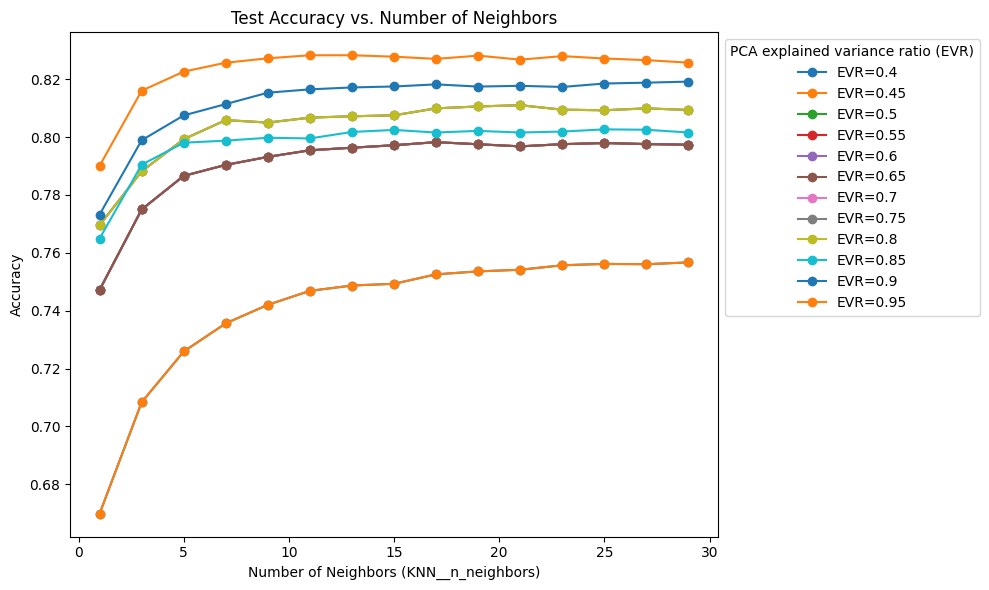

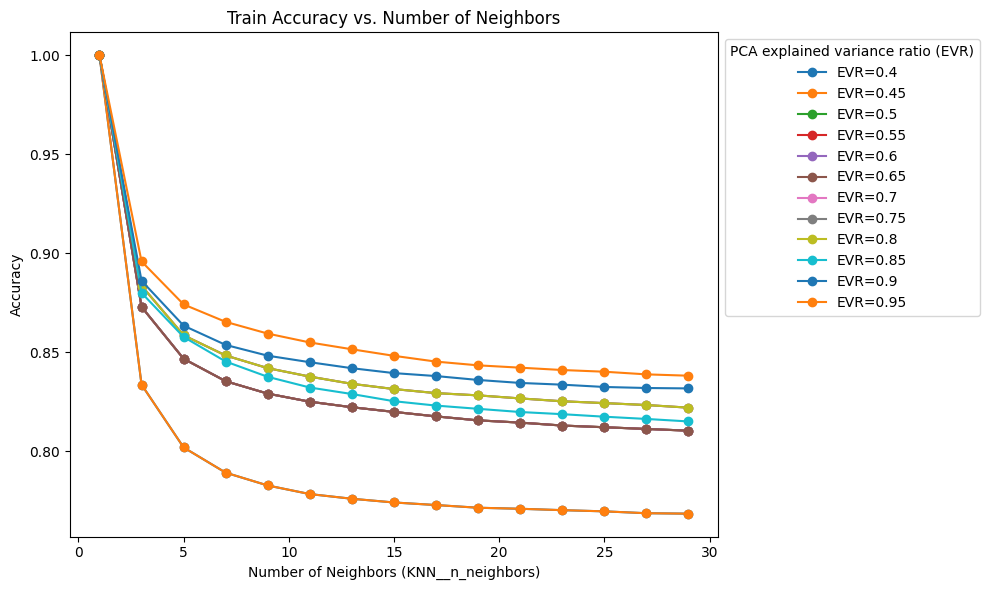

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def plot_per_hyperparam(hyperparam1, hyperparam2, hyp2_vals, label, xlabel, leg_title):
  # Retrieve the mean test scores from the cv_results
  mean_test_scores = grid_search.cv_results_['mean_test_score']
  mean_train_scores = grid_search.cv_results_['mean_train_score']

  # Get the list of hyperparameters settings from cv_results
  param_settings = [params for params in grid_search.cv_results_['params']]

  # Initialize a plot
  plt.figure(figsize=(10, 6))

  # Plot a curve for each value of PCA__n_components
  for hyp2_val in hyp2_vals:
      # Filter scores for the specific value of PCA__n_components
      scores = [mean_test_scores[i] for i in range(len(param_settings))
                if param_settings[i][hyperparam2] == hyp2_val]

      # Extract the KNN__n_neighbors values for plotting
      neighbors_values = [param_settings[i][hyperparam1] for i in range(len(param_settings))
                          if param_settings[i][hyperparam2] == hyp2_val]
      # Plot accuracy on y-axis and hyperparameters on x-axis
      plt.plot(neighbors_values, scores, marker='o', label=f'{label}={hyp2_val}')
  # Label the axes
  plt.xlabel(xlabel=xlabel)
  plt.ylabel('Accuracy')
  plt.title('Test Accuracy vs. Number of Neighbors')

  # Show the legend
  plt.legend(loc='upper left', bbox_to_anchor=(1,1), title=leg_title)
  plt.tight_layout()

  # Show the plot
  plt.show()

  plt.figure(figsize=(10, 6))
  for hyp2_val in hyp2_vals:
      # Filter scores for the specific value of PCA__n_components
      scores = [mean_train_scores[i] for i in range(len(param_settings))
                if param_settings[i][hyperparam2] == hyp2_val]

      # Extract the KNN__n_neighbors values for plotting
      neighbors_values = [param_settings[i][hyperparam1] for i in range(len(param_settings))
                          if param_settings[i][hyperparam2] == hyp2_val]
      plt.plot(neighbors_values, scores, marker='o', label=f'{label}={np.round(hyp2_val,2)}')
  # Label the axes
  plt.xlabel(xlabel=xlabel)
  plt.ylabel('Accuracy')
  plt.title('Train Accuracy vs. Number of Neighbors')

  # Show the legend
  plt.legend(loc='upper left', bbox_to_anchor=(1,1), title=leg_title)
  plt.tight_layout()

  # Show the plot
  plt.show()

plot_per_hyperparam('KNN__n_neighbors', 'PCA__n_components', pca_n_vals, 'EVR', 'Number of Neighbors (KNN__n_neighbors)', 'PCA explained variance ratio (EVR)')


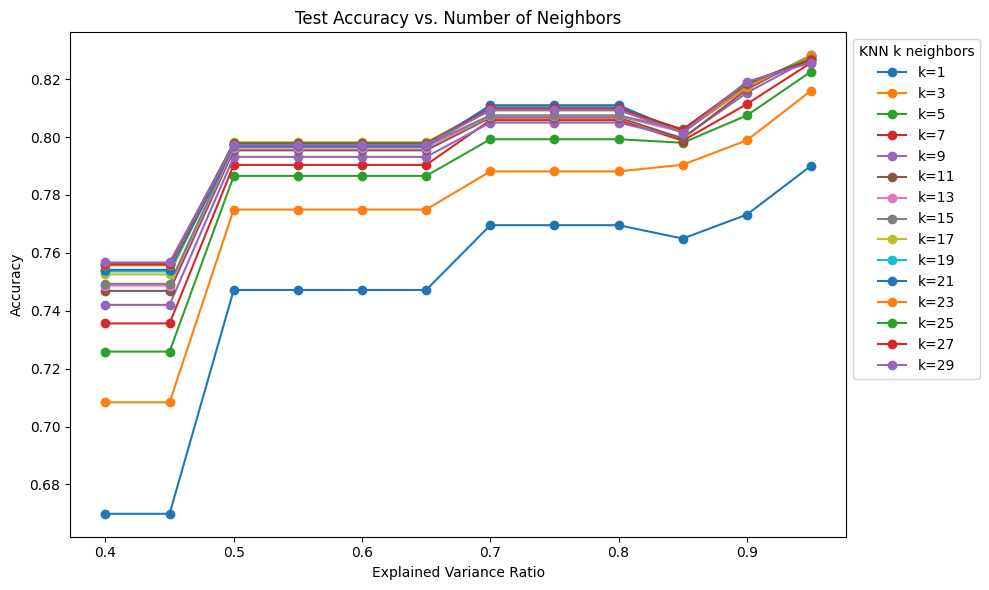

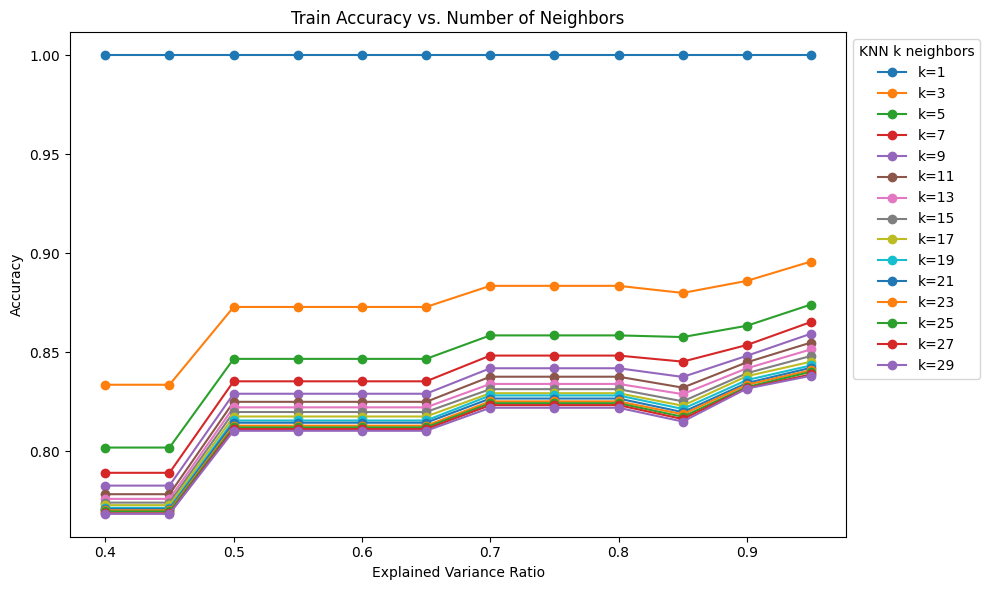

In [36]:
import matplotlib.pyplot as plt
import numpy as np

plot_per_hyperparam('PCA__n_components', 'KNN__n_neighbors', k_vals, 'k', 'Explained Variance Ratio', 'KNN k neighbors')


<Axes: >

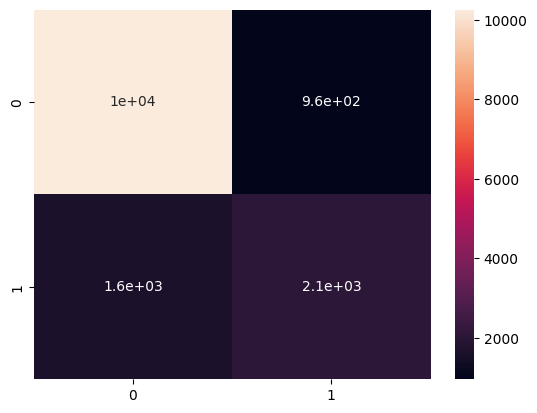

In [23]:
from sklearn.metrics import confusion_matrix
best_model = best_knn
y_predict_scaled = best_knn.predict(x_test)
cm = confusion_matrix(y_test, y_predict_scaled)
sns.heatmap(cm, annot=True)

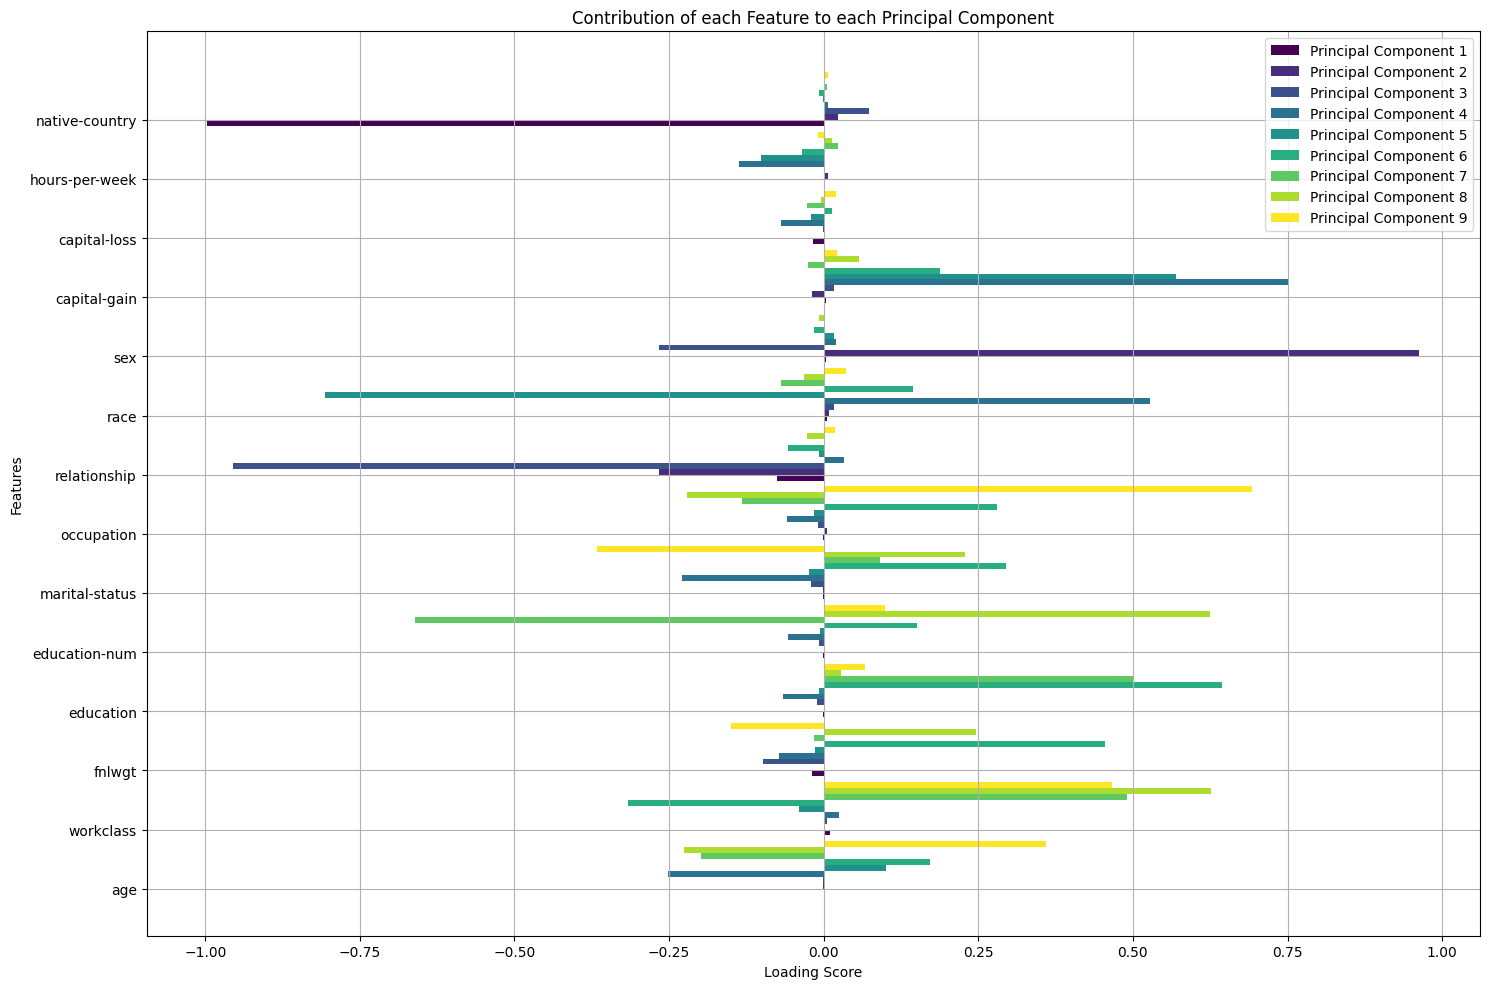

In [19]:
import matplotlib.pyplot as plt
import numpy as np

components = best_knn.named_steps['PCA'].components_
n_components = components.shape[0]
n_features = components.shape[1]

# Set up the figure size
plt.figure(figsize=(15, 10))

# Create a color map for the bars
colors = plt.cm.viridis(np.linspace(0, 1, n_components))

# Set the positions of the bars on the y-axis
ind = np.arange(n_features)
height = 0.1  # the height of the bars

# Plotting the contribution of each feature to each principal component
for i, (component, color) in enumerate(zip(components, colors)):
    component_features = dict(zip(X.columns, component))
    scores = list(component_features.values())
    plt.barh(ind + i * height, scores, height, label=f'Principal Component {i + 1}', color=color)

# Add some text for labels, title, and custom y-axis tick labels, etc.
plt.ylabel('Features')
plt.xlabel('Loading Score')
plt.title('Contribution of each Feature to each Principal Component')

# Define the position of the y-ticks
plt.yticks(ind + height / 2, X.columns)

# Adding legends
plt.legend(loc='best')

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()
